## Basic library to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm 
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline
import ipywidgets as widgets

## Specific library to import

In [2]:
import discretize
import empymod

## Project package to import

In [3]:
import Project
from Project import EMIP1D
from Project import psuedolog

In [4]:
res_air = 2e14
res_sea = 1/3
nlayers = 5
layer_thicknesses = 10
seabed_depth = 1000.1

btm_fix = False
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers)])

In [5]:
# Configuration is inspired by JOGMEC WISTEM survey
# K.Nakayama(2014)
t = np.logspace(-4,-2, 61)
tstrt = 1e-4
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]*1e3

In [6]:

model_base = {
    'src':  [1.75,1.75,-1.75,1.75,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [7]:
EMIP_obs =  EMIP1D(IP_model="pelton",model_base=model_base, 
res_air=res_air,res_sea=res_sea, nlayers=nlayers, tindex=tindex,
)

In [8]:
res = np.r_[0.2, 0.2, 0.2, 0.2, 1.0]
m_r = np.log(res)
m_m = np.r_[0.1, 0.1, 0.1, 0.1, 0.0] 
tau = np.r_[3e-3, 3e-3, 3e-3, 3e-3, 1e-3]
m_t = np.log(tau)
m_c = np.r_[0.6, 0.6, 0.6, 0.6, 0.5]
mvec_obs = np.hstack([m_r, m_m,m_t,m_c])
data_clean = EMIP_obs.predicted_data(mvec_obs)

In [9]:
relative_error=0.01
np.random.seed(0)
data_obs =  data_clean + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)

## Prepare Inversion using only resistivity

In [10]:
EMIP =  EMIP1D(IP_model="pelton",model_base=model_base, 
res_air=res_air,res_sea=res_sea, nlayers=nlayers, tindex=tindex,
chgmin= 1e-5, chgmax=1e-5, taumin= 1e-3, taumax=1e-3, cmin= 0.50, cmax=0.50)

In [11]:
res = 1.* np.ones(nlayers)
m_r = np.log(res)
m_m = 0.0 * np.ones(nlayers)
tau = 1e-3 * np.ones(nlayers)
m_t = np.log(tau)
m_c = 0.5*np.ones(nlayers)
mvec_init = np.hstack([m_r, m_m, m_t, m_c])
data_init = EMIP.predicted_data(mvec_init)

## Prepare matrix for regularization

In [12]:
EMIP.set_Wd(dobs=data_obs,dp=1,ratio=0.01,plateau=1e-5)
EMIP.set_Ws()
EMIP.set_Wx()

# Wd = EMIP.get_Wd(dobs=data_obs,dp=1,ratio=0.01,plateau=1e-4)
# Ws = EMIP.get_Ws()
# Wx = EMIP.get_Wx()

In [13]:
niter = 20
beta = 1
alphas = 1
alphax = 0.
stol= 1e-3
mu = -0.1
mvec_pred, error, mvec_itr = EMIP.GaussNewton_smooth(
    dobs=data_obs, mvec_init=mvec_init, niter=niter, 
    beta=beta, alphas=alphas, alphax=alphax,
    stol=stol,mu=mu
)
# mvec_pred, error, mvec_itr = EMIP.GaussNewton_Reg_LS(
#     dobs=data_obs, model_init=mvec_init, niter=niter,beta=beta,
#     atol=1e-14, mu= 1e-4
# )


Gauss-Newton 
 Initial phid = 6.41e+04 ,phim = 0.00e+00, error= 6.41e+04 
  1, step:2.50e-01, gradient:2.27e+04, phid:3.30e+03, phim:4.43e+00, f:3.31e+03 
  2, step:1.00e+00, gradient:2.99e+04, phid:1.69e+03, phim:1.33e+01, f:1.70e+03 
  3, step:1.00e+00, gradient:2.37e+04, phid:8.53e+02, phim:4.35e+01, f:8.97e+02 
  4, step:1.00e+00, gradient:1.46e+03, phid:6.68e+02, phim:1.13e+02, f:7.82e+02 
  5, step:1.00e+00, gradient:7.88e+03, phid:7.38e+02, phim:2.91e+01, f:7.67e+02 
  6, step:1.00e+00, gradient:6.99e+03, phid:6.51e+02, phim:1.99e+01, f:6.71e+02 
  7, step:1.00e+00, gradient:8.52e+03, phid:4.30e+02, phim:4.43e+01, f:4.74e+02 
  8, step:5.00e-01, gradient:2.96e+03, phid:4.35e+02, phim:3.15e+01, f:4.66e+02 
  9, step:1.00e+00, gradient:2.22e+03, phid:4.22e+02, phim:5.05e+01, f:4.73e+02 
 10, step:5.00e-01, gradient:1.62e+03, phid:4.27e+02, phim:3.30e+01, f:4.60e+02 
 11, step:1.00e+00, gradient:1.51e+03, phid:4.22e+02, phim:3.82e+01, f:4.60e+02 
 12, step:5.00e-01, gradient:1.26e+

In [14]:
data_pred = (EMIP.predicted_data(mvec_pred))
cmp_itr = len(error)
data_itr = np.zeros((cmp_itr,len(data_pred)))
for i, mvec_tmp in enumerate(mvec_itr):
    data_itr[i,:] = EMIP.predicted_data(mvec_tmp)

In [15]:
def plot_inversion_results_widget(ind_show):
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 4)  
    ax = [None] * 6

    ax[0] = fig.add_subplot(gs[0, 0])
    ax[1] = fig.add_subplot(gs[0, 1])
    ax[2] = fig.add_subplot(gs[1, 0])
    ax[3] = fig.add_subplot(gs[1, 1])
    ax[4] = fig.add_subplot(gs[0, 2:])
    ax[5] = fig.add_subplot(gs[1, 2:])

    axip =[ax[0], ax[1], ax[2], ax[3]]
    axip = EMIP.plot_IP_par(mvec=mvec_init, label="initial", color="k-",  ax=axip, linewidth=3.0)
    axip = EMIP.plot_IP_par(mvec=mvec_obs,  label="true",    color="b-",  ax=axip, linewidth=3.0)
    axip = EMIP.plot_IP_par(mvec=mvec_itr[ind_show], label="predicted",color="r--",ax=axip, linewidth=3.0)
    ax[0].invert_xaxis() 

    for i in range(2):
        tr_min, tr_max = ax[2*i].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i].semilogx(tr_z, model_base["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
    for i in range(2):
        tr_min, tr_max = ax[2*i+1].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i+1].plot(tr_z, model_base["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
        
    a = 1e-4
    b = 0.2
    posmax = 10**(np.log10(max(np.r_[a/10,  data_obs,  data_init]) ) // 1 +1)
    negmax = 10**(np.log10(max(np.r_[a/10, -data_obs, -data_init]) ) // 1 +1)
    data_plot = psuedolog(posmax=posmax, negmax=negmax, a=a, b=b)
    ax[4] = data_plot.pl_plot(tplot, data_init, ax=ax[4], color="k", label="initial")
    ax[4] = data_plot.pl_plot(tplot, data_obs , ax=ax[4], color="b", label="observation")
    ax[4] = data_plot.pl_scatter(tplot, data_itr[ind_show], ax=ax[4], marker="o",s=10,color="r", label="prediction")
    ax[4] = data_plot.pl_axes(ax[4])
    ax[4].set_title("Data for each model")
    ax[4].set_ylabel("dbdt")

    ax[4].legend()
    ax[4].set_xlabel("time(msec)")


    ax[5].semilogy(error,label="error value",color='black')
    ax[5].semilogy(ind_show,error[ind_show],"o",label="index", color="red")
    ax[5].semilogy(np.arange(cmp_itr), np.ones(cmp_itr) * tindex.shape[0],"--k", label="phid_target")
    ax[5].set_title("Inversion Progress")
    ax[5].set_ylabel("Error value")
    ax[5].legend()
    ax[5].grid()
    ax[5].set_xlabel("iteration")

    for i in range(4):  # Iterate over rows
        ax[i].set_ylim([1050, 990])
        ax[i].set_ylabel('depth')
        ax[i].legend()
        ax[i].grid()
        if i== 0 or i ==2:
            ax[i].set_xscale("log")
        else:
            ax[i].set_xscale("linear")
    plt.tight_layout()


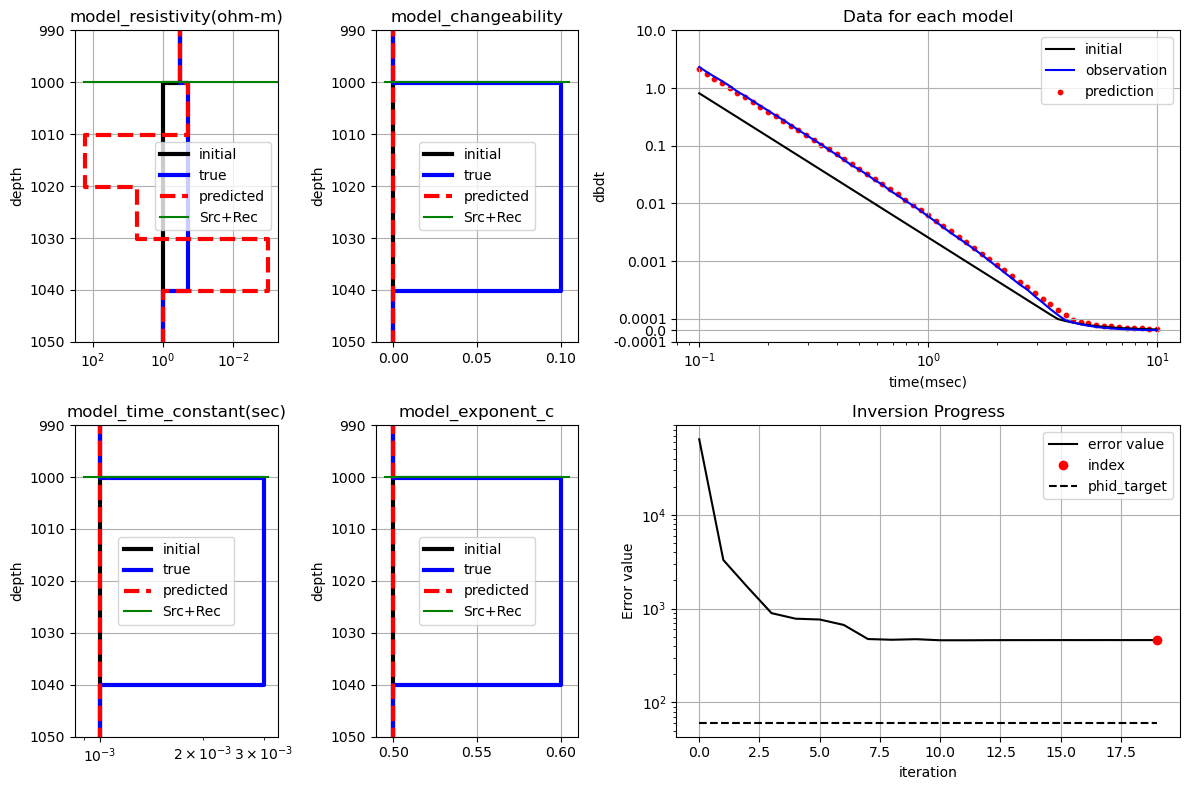

In [16]:
plot_inversion_results_widget(cmp_itr-1)
plt.savefig("4_noIP_0mh_NoNeg.png",dpi=300)
plt.show()

In [17]:
widgets.interact(plot_inversion_results_widget, 
    ind_show= widgets.IntSlider(min=0,max=cmp_itr-1,value=0))

interactive(children=(IntSlider(value=0, description='ind_show', max=19), Output()), _dom_classes=('widget-int…

<function __main__.plot_inversion_results_widget(ind_show)>